In [3]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from skimage.io import imread
from skimage.transform import resize
import requests
import string
import urllib.request
import urllib.error
from pandas import *

training_csv = read_csv("../dataset/output/dataset_mar_23/train.csv")
links = training_csv["thumbnail_link"].tolist()
labels = training_csv["trending"].tolist()

training_set = []
training_labels = []
for l in range(0,len(links)):
   print(links[l])
   try:
      image = imread(links[l], as_gray=True)
      image = resize(image, (256, 256))
      image /= 255.0
      image = image.astype('float32')
      training_set.append(image)
      training_labels.append(labels[l])
   except urllib.error.HTTPError as err:
      print("image not found")
   


train_x = np.array(training_set)
print(train_x.shape)

https://i.ytimg.com/vi/Fk1I1SjiHY8/hqdefault.jpg
https://i.ytimg.com/vi/fj3DzFrxs00/hqdefault.jpg
https://i.ytimg.com/vi/DoGeabe3baE/hqdefault.jpg
https://i.ytimg.com/vi/2PaeU_ABK94/hqdefault.jpg
https://i.ytimg.com/vi/yOBteav0s1g/hqdefault.jpg
https://i.ytimg.com/vi/1V6Utz1DpFE/hqdefault.jpg
https://i.ytimg.com/vi/k3zMUkBKjKw/hqdefault.jpg
https://i.ytimg.com/vi/lOsMsIzGOQ0/hqdefault.jpg
https://i.ytimg.com/vi/7Ay09s7QaPU/hqdefault.jpg
https://i.ytimg.com/vi/xQBCaRwgqIQ/hqdefault.jpg
https://i.ytimg.com/vi/3X-PBm-keCM/hqdefault.jpg
https://i.ytimg.com/vi/NZdxOa8LALw/hqdefault.jpg
https://i.ytimg.com/vi/hfNMIa73RA4/hqdefault.jpg
https://i.ytimg.com/vi/ViKnrHjzgn4/hqdefault.jpg
https://i.ytimg.com/vi/f4EXpaZYzt8/hqdefault.jpg
https://i.ytimg.com/vi/ZmcHmYpnhqA/hqdefault.jpg
https://i.ytimg.com/vi/cCzR4yy9MFU/hqdefault.jpg
https://i.ytimg.com/vi/AXvAqoOWo5s/hqdefault.jpg
https://i.ytimg.com/vi/ivwQ2DUjcHI/hqdefault.jpg
https://i.ytimg.com/vi/2tIW7Ezzxec/hqdefault.jpg
https://i.ytimg.com/

In [4]:
train_y = np.array(training_labels)
print(train_y.shape)

(4300,)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f92ae6ee190>)

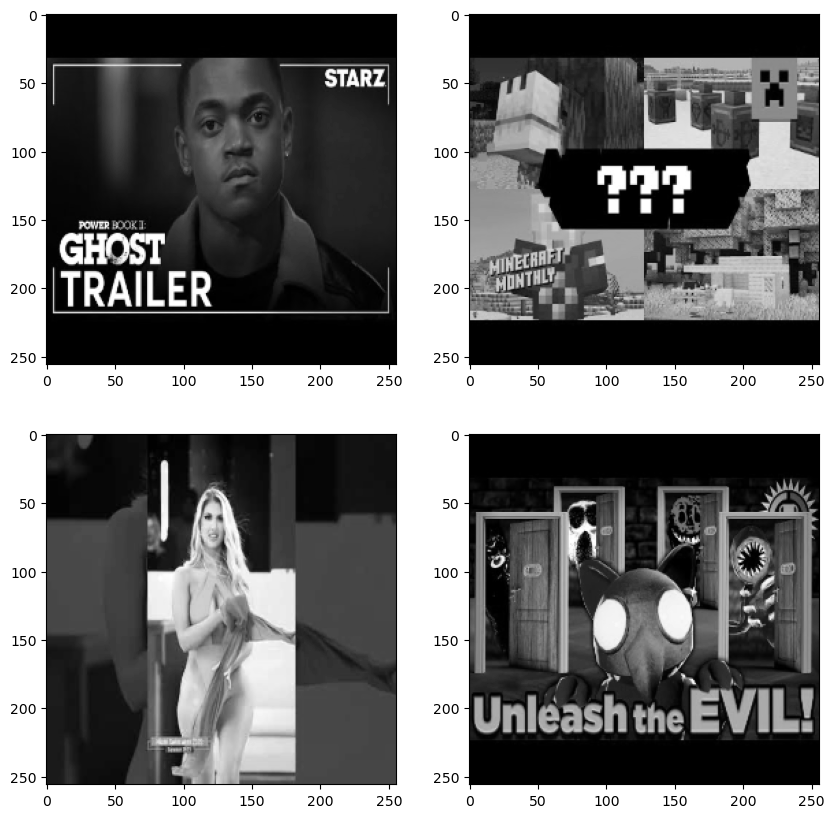

In [5]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [6]:
validation_csv = read_csv("../dataset/output/dataset_mar_23/val.csv")
linksVal = validation_csv["thumbnail_link"].tolist()
labelsVal = validation_csv["trending"].tolist()

validation_set = []
validation_labels = []
for l in range(0,len(linksVal)):
   print(linksVal[l])
   try:
      image = imread(linksVal[l], as_gray=True)
      image = resize(image, (256, 256))
      image /= 255.0
      image = image.astype('float32')
      validation_set.append(image)
      validation_labels.append(labelsVal[l])
   except urllib.error.HTTPError as err:
      print("image not found")
   


val_x = np.array(validation_set)
print(val_x.shape)
val_y = np.array(validation_labels)
print(val_y.shape)

https://i.ytimg.com/vi/5VbC-QEo-DU/hqdefault.jpg
https://i.ytimg.com/vi/1_D5EKcVXfo/hqdefault.jpg
https://i.ytimg.com/vi/ix62ySKlxb0/hqdefault.jpg
https://i.ytimg.com/vi/9irICRnszOc/hqdefault.jpg
https://i.ytimg.com/vi/w9B6G8Vty8s/hqdefault.jpg
https://i.ytimg.com/vi/EbuHMZdXMIo/hqdefault.jpg
https://i.ytimg.com/vi/94MlE9CxDCU/hqdefault.jpg
https://i.ytimg.com/vi/sTBYq7z8RyM/hqdefault.jpg
https://i.ytimg.com/vi/ym6chLjFE4I/hqdefault.jpg
https://i.ytimg.com/vi/CR_rej2B80I/hqdefault.jpg
https://i.ytimg.com/vi/oj3r5Gup75Q/hqdefault.jpg
https://i.ytimg.com/vi/y8JSLtRmcWQ/hqdefault.jpg
https://i.ytimg.com/vi/lGgQgTlR5Q0/hqdefault.jpg
https://i.ytimg.com/vi/wZuqAulxKys/hqdefault.jpg
https://i.ytimg.com/vi/UeChs_E7QnE/hqdefault.jpg
https://i.ytimg.com/vi/pUe_8btVNzg/hqdefault.jpg
https://i.ytimg.com/vi/6wiXQvsMZr0/hqdefault.jpg
https://i.ytimg.com/vi/lK1ABJm9DYk/hqdefault.jpg
https://i.ytimg.com/vi/3iP6f6CTF0U/hqdefault.jpg
https://i.ytimg.com/vi/uYY-RlpsDwM/hqdefault.jpg
https://i.ytimg.com/

In [7]:
print(val_x.shape,val_y.shape)

(1077, 256, 256) (1077,)


In [9]:
# converting training images into torch format
train_x = train_x.reshape(4300, 1, 256, 256)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
print(train_x.shape, train_y.shape)


# converting validation images into torch format
val_x = val_x.reshape(1077, 1, 256, 256)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
print(val_x.shape, val_y.shape)

torch.Size([4300, 1, 256, 256]) torch.Size([4300])
torch.Size([1077, 1, 256, 256]) torch.Size([1077])


In [16]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            #Linear(4 * 7 * 7, 10)
            Linear(16384, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [17]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=16384, out_features=10, bias=True)
  )
)


In [18]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [19]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.5265, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(231.4084, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(146.3457, grad_fn=<NllLossBackward0>)
